In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

In [4]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf= yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open','High','Low','Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed
/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_33943/4016531901.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.droplevel(0, axis=1).resample('M').last()


In [5]:
rets = data.pct_change().fillna(0)

In [6]:
pal = sns.color_palette('Spectral', len(tickers))

## EMV(Equal_Marginal_Volatility) PF

In [7]:
vol = rets.std() * np.sqrt(12)
# 역변동성 
inv_vol = 1/vol
#역변동성을 비중으로 하는 가중치 산출
weights = inv_vol/inv_vol.sum()

In [8]:
vol

Ticker
XLB    0.191392
XLE    0.270373
XLF    0.189551
XLI    0.179174
XLK    0.176787
XLP    0.119276
XLU    0.140900
XLV    0.133677
XLY    0.184098
dtype: float64

In [9]:
inv_vol

Ticker
XLB    5.224886
XLE    3.698588
XLF    5.275634
XLI    5.581159
XLK    5.656532
XLP    8.383881
XLU    7.097229
XLV    7.480712
XLY    5.431902
dtype: float64

In [10]:
weights
# XLE 가 제일 변동성 커

Ticker
XLB    0.097062
XLE    0.068708
XLF    0.098005
XLI    0.103680
XLK    0.105080
XLP    0.155746
XLU    0.131844
XLV    0.138968
XLY    0.100907
dtype: float64

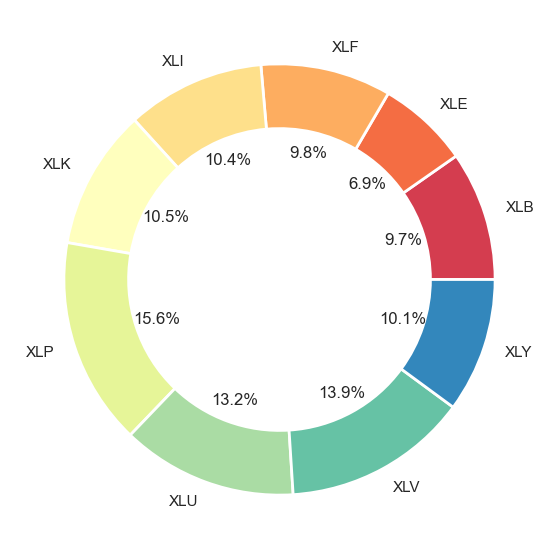

In [11]:
weights_df = pd.Series(np.round(weights, 4), index=tickers)
weights_df = weights_df[weights_df > 0] 

plt.figure(figsize=(7,7))
wedgeprops = {'width':0.3, 'edgecolor':'w', 'linewidth':2}
plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [12]:
# EMV 포트폴리오 가중치 계산 함수
def get_emv_weights(cov):
    vol = np.diag(cov)
    inv_vol = 1 / vol
    weights = inv_vol / inv_vol.sum()
    return weights

In [13]:
# 빈 데이터프레임 생성
emv_w_df = pd.DataFrame().reindex_like(rets)

# 공분산행렬의 3차원 배열 생성
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

# EMV 가중치 산출
for i in range(12, len(emv_w_df)):
    emv_w_df.iloc[i] = get_emv_weights(cov[i-1])


Text(0, 0.5, 'Weights')

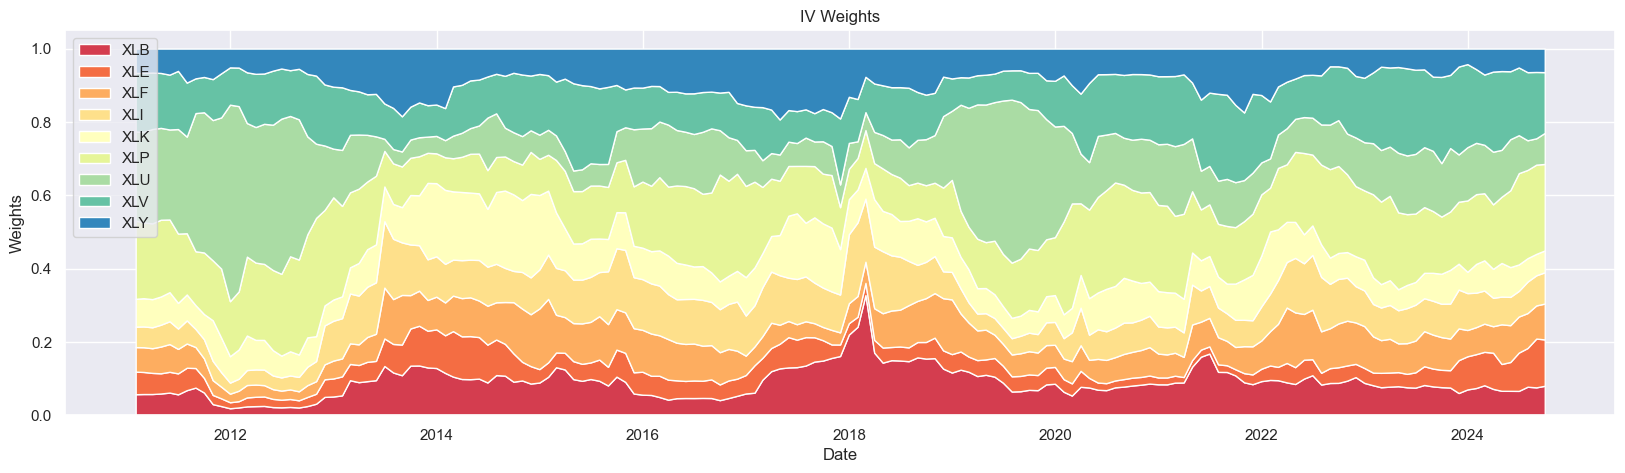

In [14]:
# 시계열 가중치 플랏 시각화
plt.figure(figsize=(20, 5))
plt.stackplot(emv_w_df.index, emv_w_df.T, labels=emv_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('IV Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Text(0.5, 1.0, 'IV Backtest')

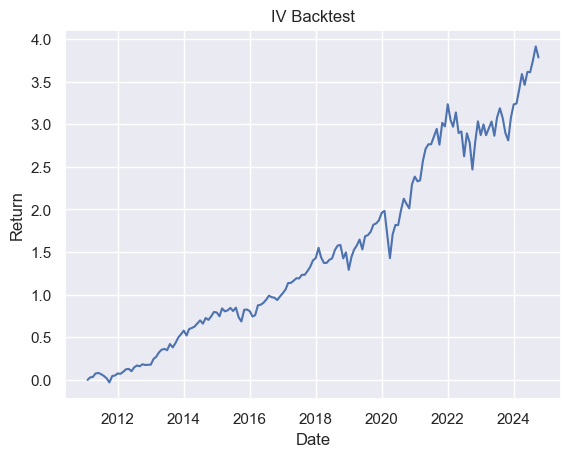

In [15]:
# EMV 포트폴리오 수익률
port_rets = emv_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# 백테스팅 시각화
plt.plot(port_cum_rets.iloc[12:])
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('IV Backtest')